# Анализ расходов на маркетинг и эффективности рекламных кампаний

**Описание проекта**

У нас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Нам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

**Цель проекта:**

Разобраться в причинах убытков компании при огромных вложениях в рекламу.

**Задачи:**

1. Предобработка данных;
2. Исследовательский анализ данных;
3. Исследование расходов на маркетинг;
4. Оценка окупаемости рекламы:
    - расчёт и анализ показателей LTV, CAC и ROI;
    - расчёт и анализ конверсии и удержания.

## Предобработка данных

Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

Откроем файлы с данными:

Рассмотрим каждый из датасетов в отдельности:

In [3]:
display(visits.info())
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Приведём названия столбцов в таблице visits к snake case:

In [4]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

И изменим тип данных в столбцах session_start и session_end:

In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

Убедимся, что все изменения внесены:

In [6]:
display(visits.info())
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


None

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Проверим таблицу на наличие дубликатов:

In [7]:
visits.duplicated().sum()

0

Также проверим столбцы region, device и channel на наличие неявных дубликатов:

In [8]:
display(sorted(visits['region'].unique()))
display(sorted(visits['device'].unique()))
display(sorted(visits['channel'].unique()))

['France', 'Germany', 'UK', 'United States']

['Android', 'Mac', 'PC', 'iPhone']

['AdNonSense',
 'FaceBoom',
 'LeapBob',
 'MediaTornado',
 'OppleCreativeMedia',
 'RocketSuperAds',
 'TipTop',
 'WahooNetBanner',
 'YRabbit',
 'lambdaMediaAds',
 'organic']

Дубликаты в таблице отсутствуют.

Произведём те же действия с таблицей orders:

In [9]:
display(orders.info())
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [10]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [11]:
display(orders.info())
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


None

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [12]:
orders.duplicated().sum()

0

Дубликаты в таблице отсутствуют.

Аналогично поступим с таблицей costs:

In [13]:
display(costs.info())
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [14]:
costs.columns = costs.columns.str.lower()
costs['dt'] = pd.to_datetime(costs['dt'])

In [15]:
display(costs.info())
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB


None

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [16]:
costs.duplicated().sum()

0

In [17]:
sorted(costs['channel'].unique())

['AdNonSense',
 'FaceBoom',
 'LeapBob',
 'MediaTornado',
 'OppleCreativeMedia',
 'RocketSuperAds',
 'TipTop',
 'WahooNetBanner',
 'YRabbit',
 'lambdaMediaAds']

Дубликаты в таблице отсутствуют.

В процессе предобработки данных была рассмотрена информация о таблицах, используемых для анализа. Таблицы проверены на наличие в них пропусков и дубликатов: ни те, ни другие не были обнаружены. Были изменены типы данных (приведены к формату даты/времени) для корректного использования данных в анализе. Также изменены названия столбцов в таблицах для удобства работы с ними.

## Aункции для расчета и анализа LTV, ROI, удержания и конверсии

Зададим функцию **get_profiles** для создания профилей пользователей. Функция принимает на вход следующие параметры:
- **sessions** - таблица, содержащая данные о пользовательских сессиях;
- **orders** - таблица, содержащая данные о покупках пользователей;
- **ad_costs** - таблица, содержащая данные о затратах на рекламу.

Функция возвращает таблицу с данными о дате первого посещения приложения, первом дне месяца посещения и показателем CAC для каждого пользователя.

In [18]:
def get_profiles(sessions, orders, ad_costs):

    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date

    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

Зададим функцию **get_retention** для расчёта коэффициента удержания. Фукнция принимает на вход следующие параметры:
- **profiles** - данные профилей пользователей;
- **sessions** - данные пользовательских сессий;
- **observation_date** - момент анализа;
- **horizon_days** - горизонт анализа;
- **dimensions** - параметр группировки;
- **ignore_horizon** - опция игнорирования горизонта анализа, по умолчанию - False.

Функция возвращает:
- сырые данные на случай, если понадобится найти ошибку в расчётах;
- таблицу коэффициентов удержания;
- таблицу динамики удержания.

In [19]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    dimensions = ['payer'] + dimensions

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

Зададим функцию **get_conversion** для расчёта коэффициента конверсии. Функция принимает на вход следующие параметры:
- **profiles** - данные профилей пользователей;
- **purchases** - данные о покупках пользователей;
- **observation_date** - момент анализа;
- **horizon_days** - горизонт анализа;
- **dimensions** - параметр группировки;
- **ignore_horizon** - опция игнорирования горизонта анализа, по умолчанию - False.

Функция возвращает:
- сырые данные на случай, если понадобится найти ошибку в расчётах;
- таблицу коэффициентов конверсии;
- таблицу динамики конверсии.

In [20]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time 

Зададим функцию **get_ltv** для расчёта метрики LTV (общая сумма выручки с одного клиента в среднем). Функция принимает на вход следующие параметры:
- **profiles** - данные о профилях пользователей;
- **purchases** - данные о покупках пользователей;
- **observation_date** - момент анализа;
- **horizon_days** - горизонт анализа;
- **dimensions** - параметр группировки;
- **ignore_horizon** - опция игнорирования горизонта анализа, по умолчанию - False.

Функция возвращает:
- сырые данные на случай, если понадобится найти ошибку в расчётах;
- таблицу с данными об LTV;
- таблицу динамики LTV;
- таблицу с данными об ROI;
- таблицу динамики ROI.

In [21]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        roi = result.div(cac['cac'], axis=0)

        roi = roi[~roi['cohort_size'].isin([np.inf])]

        roi['cohort_size'] = cohort_sizes

        roi['cac'] = cac['cac']

        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,
        result_grouped,
        result_in_time,
        roi_grouped,
        roi_in_time,
    )

Зададим функцию **plot_retention** для визуализации удержания пользователей. Функция принимает на вход следующие параметры:
- **retention** - данные о коэффициентах удержания;
- **retention_history** - данные о динамике удержания;
- **horizon** - горизонт анализа.

Функция возвращает сетку графиков удержания и динамики удержания с разбиением по платящим и неплатящим клиентам.

In [22]:
def plot_retention(retention, retention_history, horizon, window):
    plt.subplots(figsize = (15, 10))
    
    def filter_data(df, window):
        for column in df.columns.values:
            df[column] = df[column].rolling(window).mean() 
        return df
    
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users' 
        retention = retention.reset_index().set_index(['cohort', 'payer']) 
    
    retention = retention.drop(columns = ['cohort_size', 0]) 
    retention_history = retention_history.drop(columns = ['cohort_size'])[[horizon - 1]]
    
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid = True, ax = ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Удержание платящих пользователей')  
    
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid = True, ax = ax2)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Удержание неплатящих пользователей')
    
    ax3 = plt.subplot(2, 2, 3)
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']] 
    filtered_data = retention_history.query('payer == True').pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))  
    
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(index = 'dt', columns = columns, values = horizon - 1, aggfunc = 'mean')
    filter_data(filtered_data, window).plot(grid = True, ax = ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))   
    
    plt.tight_layout() 
    
    plt.show()

Зададим функцию **plot_conversion** для визуализации конверсии пользователей. Функция принимает на вход следующие параметры:
- **conversion** - данные о коэффициентах конверсии;
- **conversion_history** - данные о динамике конверсии;
- **horizon** - горизонт анализа;
- **window** - окно сглаживания для расчёта скользящего среднего.

In [23]:
def plot_conversion(conversion, conversion_history, horizon, window):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    
    def filter_data(df, window):
        for column in df.columns.values:
            df[column] = df[column].rolling(window).mean() 
        return df
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Зададим функцию **plt_ltv_roi** для визуализации окупаемости. Функция принимает на вход следующие параметры:
- **ltv** - данные о метрике LTV;
- **ltv_history** - данные о динамике LTV;
- **roi** - данные о метрике ROI (окупаемость инвестиций);
- **roi_history** - данные о динамике ROI;
- **horizon** - горизонт анализа;
- **window** - окно сглаживания для расчёта скользящего среднего.

Функция возвращает:
- кривые LTV;
- кривые ROI;
- график динамики LTV;
- график динамики ROI;
- график динамики CAC.

In [24]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    
    def filter_data(df, window):
        for column in df.columns.values:
            df[column] = df[column].rolling(window).mean() 
        return df
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

Для создания пользовательских профилей воспользуемся определённой ранее функцией **get_profiles**:

In [25]:
profiles = get_profiles(visits, orders, costs)

Определим минимальную и максимальную даты привлечения пользователей:

In [26]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [27]:
min_date = profiles['first_ts'].min()
max_date = profiles['first_ts'].max()
display(min_date)
display(max_date)

Timestamp('2019-05-01 00:00:41')

Timestamp('2019-10-27 23:59:04')

Посмотрим распредление общего количества пользователей и доли платящих пользователей по странам:

In [28]:
profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'})\
                           .rename(columns = {'user_id': 'total_users', 'payer': 'payer_mean'})\
                           .sort_values(by = 'payer_mean', ascending = False)\
                           .style.format({'total_users': '{:.0f}',
                                          'payer_mean': '{:.4f}'})

,total_users,payer_mean
region,,
United States,100002,0.0690
Germany,14981,0.0411
UK,17575,0.0398
France,17450,0.0380


Из таблицы видим, что в США не только наибольшее абсолютное количество пользователей, но и доля платящих пользователей - около 7%. 

При этом доля платящих пользователей из США значительно выше, чем в остальных регионах (почти 7% против 4% в среднем для остальных регионов).

Рассмотрим аналогичное распределение пользователей по устройствам:

In [29]:
profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'mean'})\
                          .rename(columns = {'user_id': 'total_users', 'payer': 'payer_mean'})\
                          .sort_values(by = 'payer_mean', ascending = False)\
                          .style.format({'total_users': '{:.0f}',
                                          'payer_mean': '{:.4f}'})

,total_users,payer_mean
device,,
Mac,30042,0.0636
iPhone,54479,0.0621
Android,35032,0.0585
PC,30455,0.0505


Здесь видим наибольшую долю платящих пользователей, использующих Mac (6,36%), однако пользователи iPhone и Android отстают незначительно (6,21% и 5,85% соответственно). А вот доля платящих пользователей персональных компьютеров значительно ниже - всего 5,05%.

 Далее проверим, как распределяются платящие и неплатящие пользователи в зависимости от канала их привлечения:

In [30]:
profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'mean'})\
                          .rename(columns = {'user_id': 'total_users', 'payer': 'payer_mean'})\
                          .sort_values(by = 'payer_mean', ascending = False)\
                          .style.format({'total_users': '{:.0f}',
                                          'payer_mean': '{:.4f}'})

,total_users,payer_mean
channel,,
FaceBoom,29144,0.1220
AdNonSense,3880,0.1134
lambdaMediaAds,2149,0.1047
TipTop,19561,0.0960
RocketSuperAds,4448,0.0791
WahooNetBanner,8553,0.0530
YRabbit,4312,0.0383
MediaTornado,4364,0.0357
LeapBob,8553,0.0306


Наибольшая доля платящих клиентов была привлечена с канала FaceBoom (12,2%), а наименьшая доля ожидаемо пришла из органического трафика (2,06%).

На этапе исследователького анализа данных было рассмотрено распределение привлечённых платящих пользователей приложения в зависимости от региона, устройства и канала их привлечения. Выявлено, что наибольшие доли относятся к:
- пользователям из США;
- пользователям Mac;
- пользователям, привлечённых с FaceBoom.

Наименьшие доли платящих пользователей - это:
- пользователи из Франции;
- пользователи ПК;
- "органические" пользователи, т.е. установившие приложение не с рекламного объявления.

Однако этих данных недостаточно, чтобы формулировать окончательные выводы и рекомендации, поэтому далее проведём анализ маркетиговых расходов и окупаемости рекламы.

## Анализ расходов на маркетинг

Посчитаем, в какую сумму обошлись все рекламные кампании за рассматриваемый период:

In [31]:
costs['costs'].sum()

105497.30000000002

Посмотрим на распределение затраченных сумм по источникам:

In [32]:
costs_rate = costs.pivot_table(index = 'channel', values = 'costs', aggfunc = 'sum')
costs_rate['rate'] = costs_rate['costs'] / costs['costs'].sum()
costs_rate = costs_rate.sort_values(by = 'rate', ascending = False)
costs_rate.style.format({'costs': '{:.2f}',
                         'rate': '{:.4f}'})

,costs,rate
channel,,
TipTop,54751.30,0.5190
FaceBoom,32445.60,0.3075
WahooNetBanner,5151.00,0.0488
AdNonSense,3911.25,0.0371
OppleCreativeMedia,2151.25,0.0204
RocketSuperAds,1833.00,0.0174
LeapBob,1797.60,0.0170
lambdaMediaAds,1557.60,0.0148
MediaTornado,954.48,0.0090


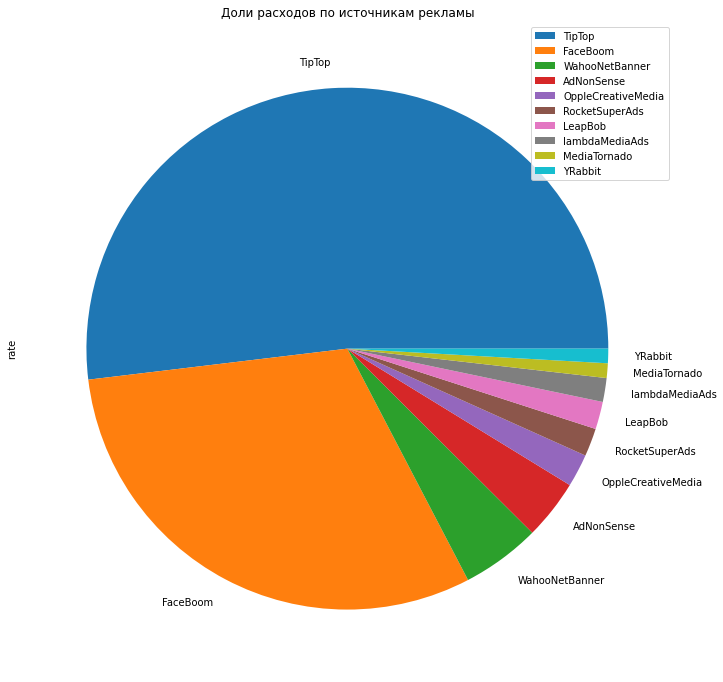

In [33]:
costs_rate.plot(kind = 'pie', y = 'rate', figsize = (12, 12))
plt.legend()
plt.title('Доли расходов по источникам рекламы')
plt.show();

Около половины рекламного бюджета ушло на рекламу в TipTop, также значительную долю в расходах занимает FaceBoom. На каждый из остальных источников было потрачено менее 5% бюджета.

А также рассмотрим на распределение затраченных сумм по неделям в разрезе разных источников:

In [34]:
costs['dt_week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

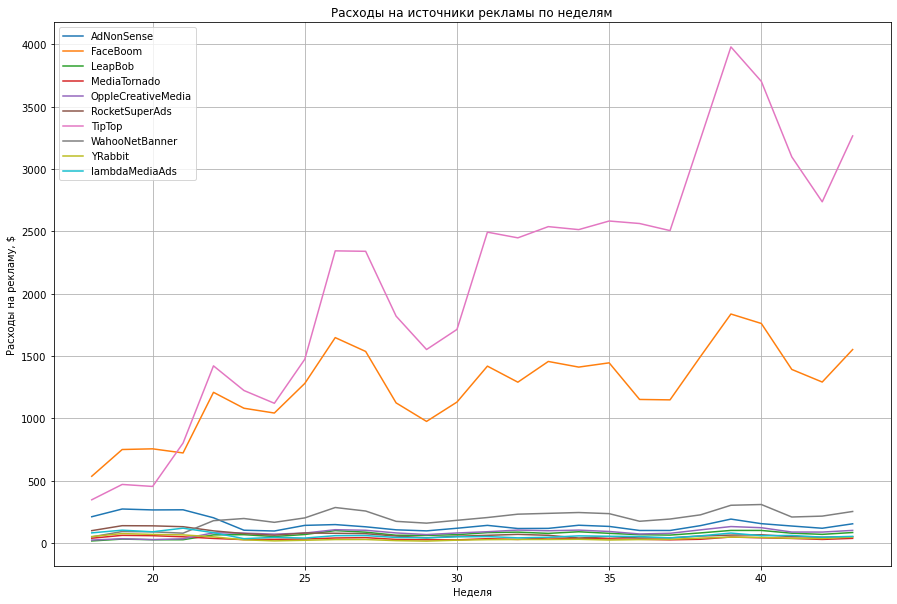

In [35]:
costs_channel = costs.pivot_table(index = 'channel', columns = 'dt_week', values = 'costs', aggfunc = 'sum')
costs_channel.T.plot(grid = True, figsize = (15, 10))
plt.legend()
plt.xlabel('Неделя')
plt.ylabel('Расходы на рекламу, $')
plt.title('Расходы на источники рекламы по неделям')
plt.show();

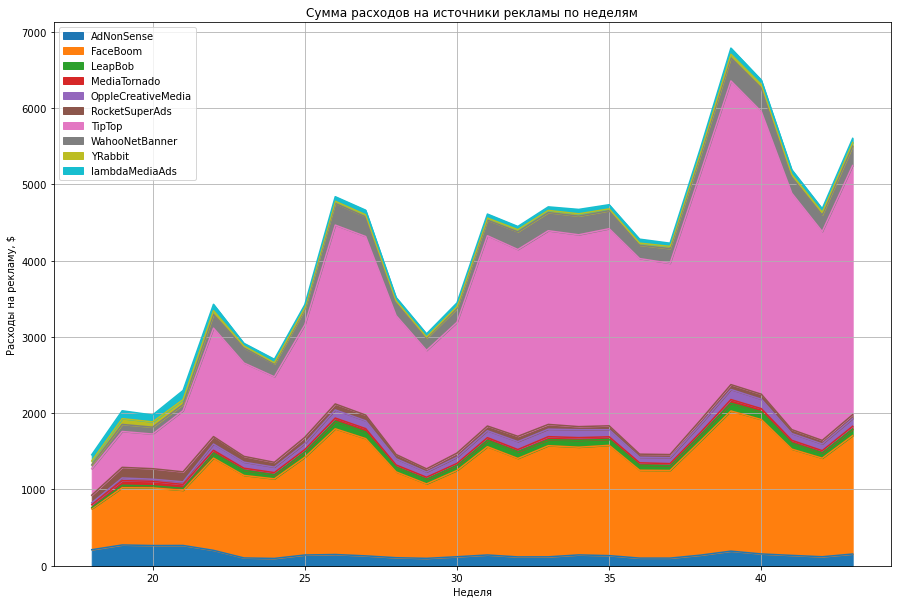

In [36]:
costs_channel.T.plot.area(grid = True, figsize = (15, 10))
plt.legend()
plt.xlabel('Неделя')
plt.ylabel('Расходы на рекламу, $')
plt.title('Сумма расходов на источники рекламы по неделям')
plt.show();

По графику видно, что расходы на рекламу в TipTop и FaceBoom на протяжении рассматриваемого периода увеличиваются почти каждую неделю (за исключением 26-29 и 35-37 недель). Для остальных же источников расходы на рекламу значительно ниже и примерно равномерны на протяжении рассматриваемого периода.

Рассчитаем, сколько долларов стоит в среднем привлечение одного клиента. Для этого разделим общую сумму маркетинговых инвестиций на общее количество привлечённых пользователей приложения:

In [37]:
cac = costs['costs'].sum() / visits['user_id'].nunique()
cac

0.703277825182657

А также посмотрим на этот показатель, исключив из расчёта "органических" пользователей:

In [38]:
cac_ad = costs[costs['channel'] != 'organic']['costs'].sum() / visits[visits['channel'] != 'organic']['user_id'].nunique()
cac_ad

1.1099370844205034

При расчёте показателя без исключения "органических" пользователей стоимость привлечения занижается на 0,4$.

Но эта сумма слишком общая, поэтому рассчитаем также показатели для каждого из источников трафика в отдельности. Показатель САС для каждого из пользователей уже получен при использовании функции get_profiles и добавлен в столбец acquisition_cost. Произведём расчёт показателей для каждого источника трафика:

In [39]:
profiles[profiles['channel'] != 'organic'].pivot_table(index = 'channel', 
                                                       values = 'acquisition_cost', 
                                                       aggfunc = 'mean')\
        .sort_values(by = 'acquisition_cost', ascending = False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


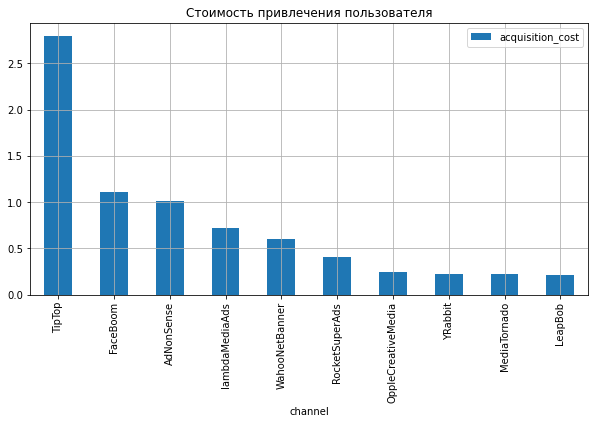

In [40]:
profiles[profiles['channel'] != 'organic'].pivot_table(index = 'channel', values = 'acquisition_cost', aggfunc = 'mean')\
        .sort_values(by = 'acquisition_cost', ascending = False)\
        .plot(kind = 'bar', grid = True, figsize = (10, 5))
plt.title('Стоимость привлечения пользователя');

Дороже всего обходятся пользователи, привлечённые из TipTop - это логично соотносится с наибольшими затратами на рекламу именно в этом источнике. Стоимость привлечения пользователей из следующих по величине затрат источников (FaceBoom и AdNonSense) меньше примерно в 2,5 раза.

Анализ маркетинговых затрат показал, что за исследуемый период в целом в рекламу было вложено 105497.3$. Большая часть этих средств была вложена в привлечение трафика из источников TipTop (52% затрат) и FaceBoom (почти 31% затрат). При этом на протяжении рассматриваемого периода рекламные вложения в трафик из этих источников постоянно росли. Кроме того, расчёт стоимости привлечения пользователей показал, что пользователи из этих источников обходятся дороже всего, и пользователи из TipTop дороже пользователей из FaceBoom почти в 2,5 раза.

Также установлена важность исключения из дальнейшего анализа "органических" пользователей - они занижают среднюю стоимость привлечения пользователя на 0,4$.

## Оценка окупаемости

### Анализ общей окупаемости рекламы

Рассчитаем и визуализируем общую окупаемость рекламы. Для этого вызовем функцию get_ltv, не передавая ей аргумент для группировки. Перед этим зададим в качестве момента анализа 01.11.2019, а в качестве горизонта анализа - 14 дней. Здесь и далее исключим из анализа "органических" пользователей:

In [41]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles_ad = profiles[profiles['channel'] != 'organic']

In [42]:
raw_data, ltv, ltv_history, roi, roi_history = get_ltv(profiles_ad,
                                                      orders,
                                                      observation_date,
                                                      horizon_days)

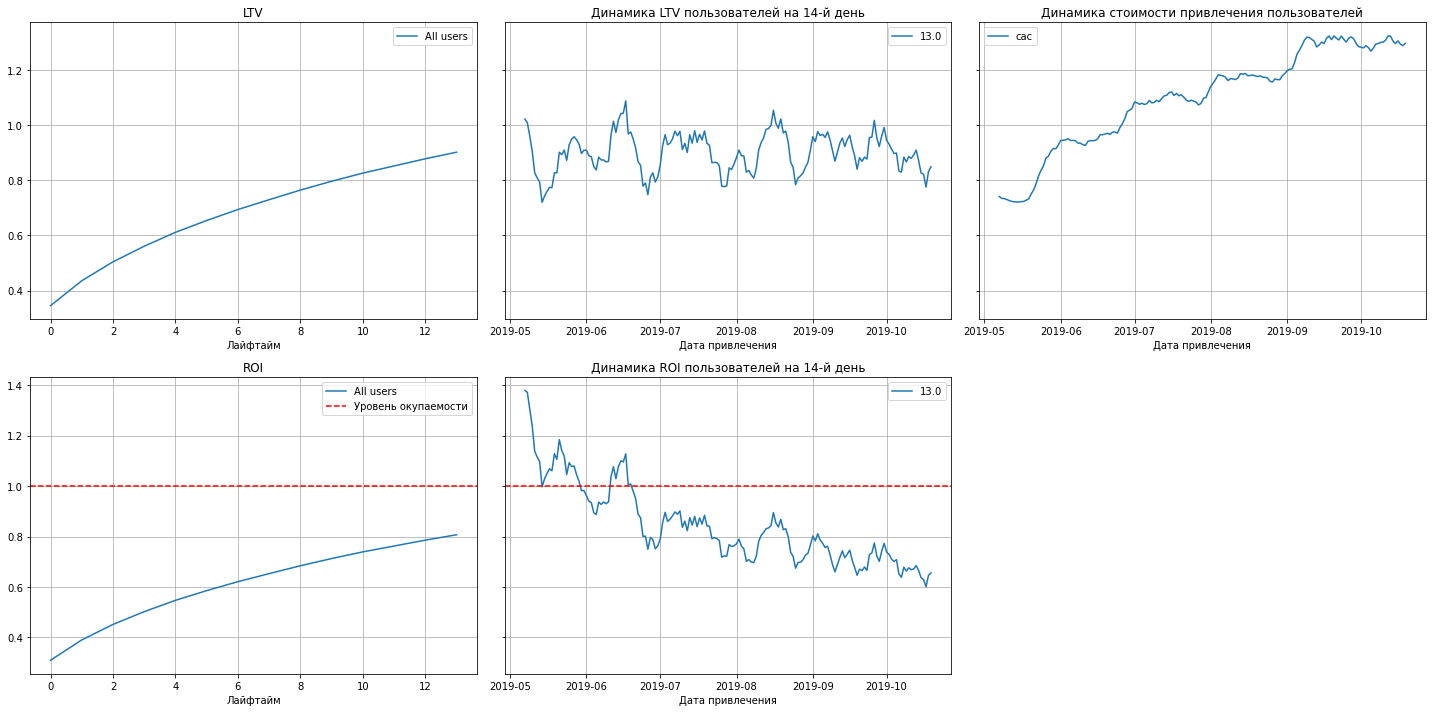

In [43]:
plot_ltv_roi(ltv, 
             ltv_history, 
             roi, 
             roi_history, 
             horizon_days, 
             7)

За весь рассматриваемый период показатель ROI так и не достиг уровня окупаемости, при этом показатель CAC рос на протяжении почти всего периода. То есть стоимость привлечения пользователей стабильно возрастала, расходы на рекламу росли, реклама не окупилась. Хотя график динамики ROI на 14 день показывает, что для пользователей, привлечённых до конца июня, рекламные кампании окупались.

### Анализ окупаемости рекламы с разбивкой по устройствам

Для анализа окупаемости рекламы с разбивкой по устройствам вызовем те же функции, но в качестве аргумента dimensions передадим device:

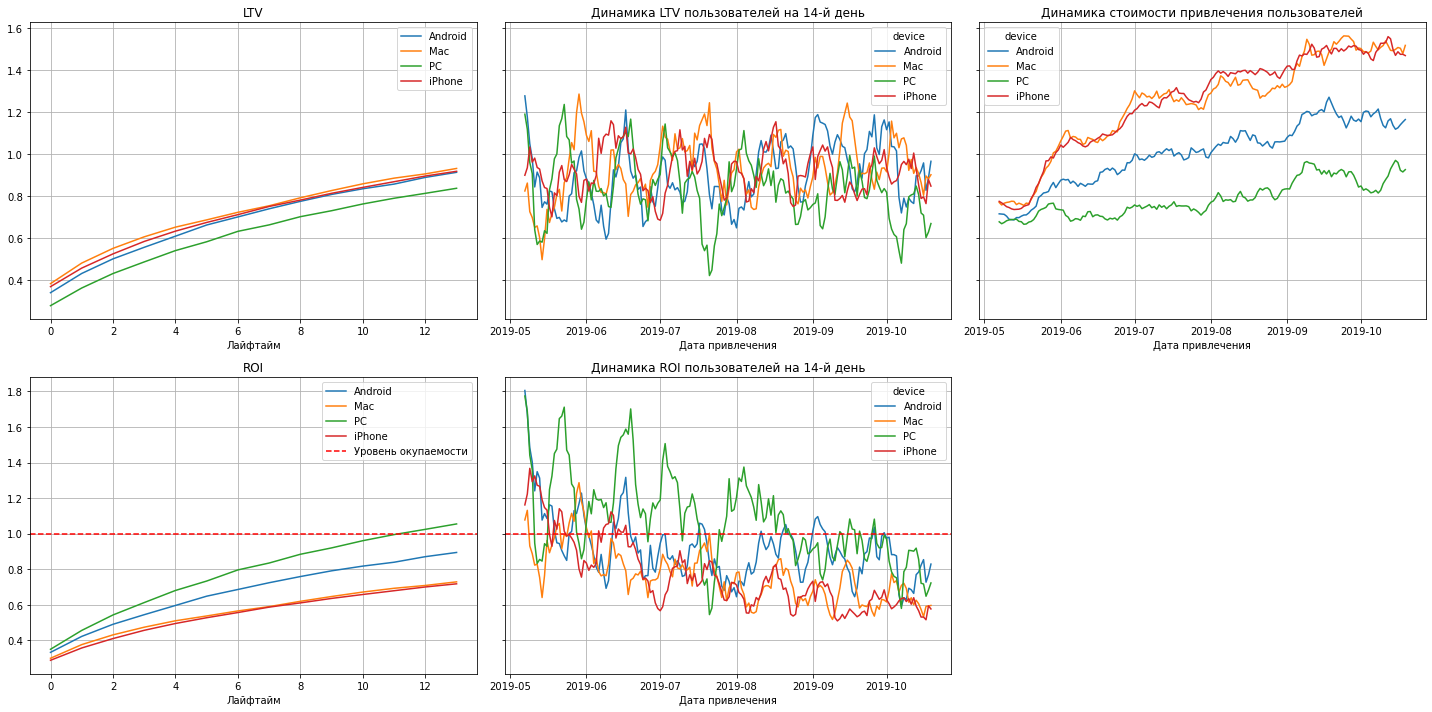

In [44]:
raw_device_data, ltv_device, ltv_device_history, roi_device, roi_device_history = get_ltv(profiles_ad,
                                                                                          orders,
                                                                                          observation_date,
                                                                                          horizon_days,
                                                                                          dimensions = ['device'])

plot_ltv_roi(ltv_device, 
             ltv_device_history, 
             roi_device, 
             roi_device_history, 
             horizon_days, 
             7)

Для каждого из устройств стоимость привлечения пользователей также росла на протяжении всего периода анализа, но при этом рекламные кампании, нацеленные на пользователей Mac, iPhone и Android не окупились вовсе, а вот пользователи ПК - окупаются. Стоит выяснить, в чём отличие поведения пользователей-владельцев устройств Apple (их окупаемость ниже всего) - возможно, функционал приложения на этих устройствах работает неожиданным образом или пользователи сталкиваются с какими-либо ошибками при использовании приложения или при попытке оплаты.

Посмотрим на удержание пользователей в разрезе используемых устройств.

In [45]:
retention_device_raw, retention_device, retention_device_history = get_retention(profiles_ad,
                                                                                visits,
                                                                                observation_date,
                                                                                horizon_days,
                                                                                ['device'])

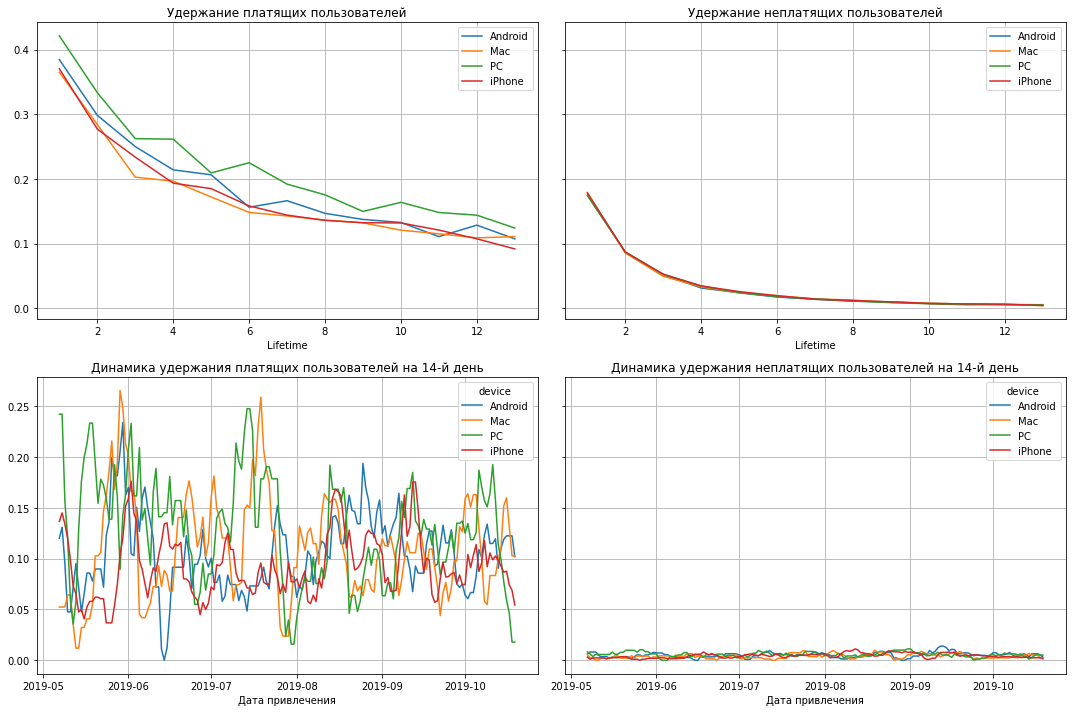

In [46]:
plot_retention(retention_device, 
               retention_device_history, 
               14, 
               7)

Удержание платящих пользователей персональных компьютеров немного выше, чем пользователей других устройств, хотя в целом для всех устройств удержание примерно одинаково - в среднем около 25%. А вот динамика удержания на 14 день отличается более высоким удержанием для пользователей ПК и Mac, привлечённых в середине-конце мая (около 25%), также выделяются пользователи ПК и Mac, привлечённые в середине июля (также около 25%).

Проверим конверсию в разрезе устройств. 

In [47]:
conversion_device_raw, conversion_device, conversion_device_history = get_conversion(profiles_ad,
                                                                                     orders,
                                                                                     observation_date,
                                                                                     horizon_days,
                                                                                     ['device'])

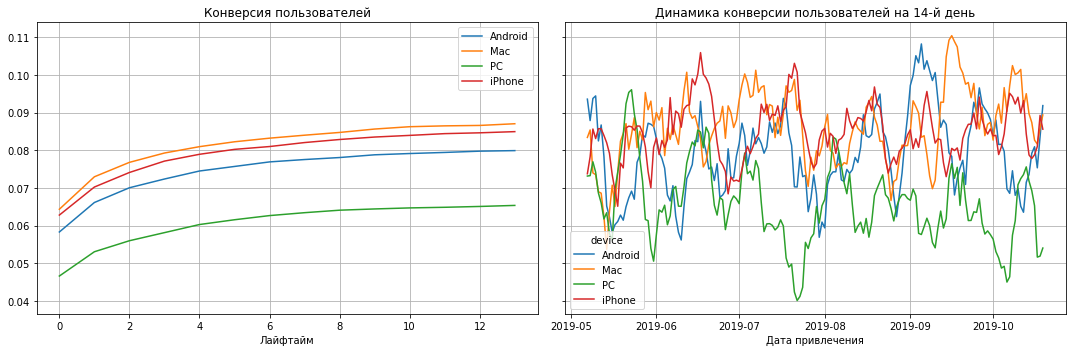

In [48]:
plot_conversion(conversion_device, 
                conversion_device_history, 
                14, 
                7)

А вот конверсия пользователей персональных компьютеров гораздо ниже, чем для других устройств. Эту информацию стоило бы передать коллегам из отдела маркетинга - проводя рекламные кампании с бóльшим уклоном в сторону пользователей персональных компьютеров тоже можно было бы увеличить прибыль, ведь как раз эти пользователи показывают наивысший показатель удержания и наиболее высокую окупаемость. Выходит, что в целом данной категории пользователей нравятся платные функции приложения, но доля конвертируемых пользователей в платных не так уж велика. Возможно, стоит поработать над содержанием рекламных кампаний.

### Анализ окупаемости рекламы с разбивкой по странам

Рассмотрим те же показатели с разбивкой по странам:

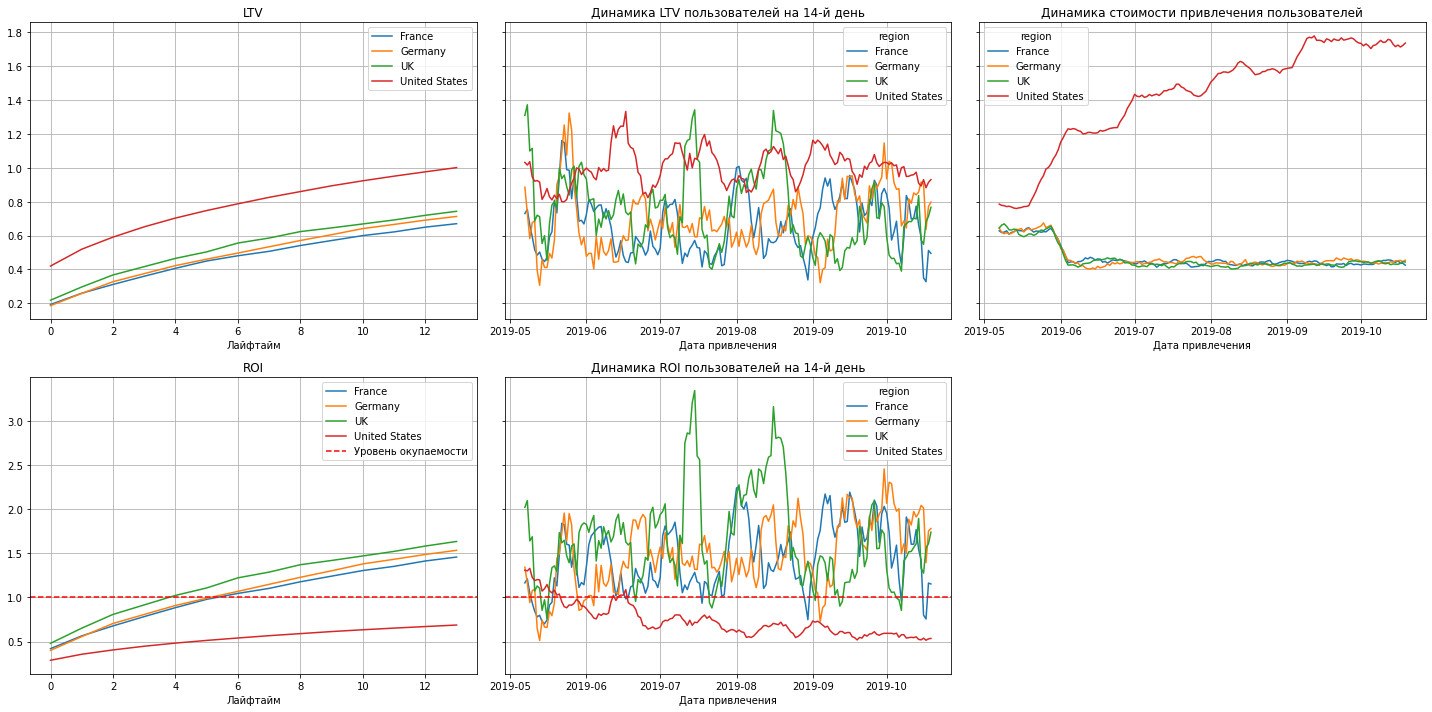

In [49]:
raw_region_data, ltv_region, ltv_region_history, roi_region, roi_region_history = get_ltv(profiles_ad,
                                                                                          orders,
                                                                                          observation_date,
                                                                                          horizon_days,
                                                                                          dimensions = ['region'])

plot_ltv_roi(ltv_region, 
             ltv_region_history, 
             roi_region, 
             roi_region_history, 
             horizon_days, 
             7)

Ситуация, которую демонстрируют графики, очень интересная: США - единственная страна, для которой стоимость пользователя росла на протяжении всего периода, и единственная страна, рекламные кампании в которой не окупились. В то же время пользователи всех остальных регионов окупились примерно в полтора раза при снижении маркетинговых затрат относительно первого месяца.

Рассмотрим удержание пользователей в разрезе стран. 

In [50]:
retention_country_raw, retention_country, retention_country_history = get_retention(profiles_ad,
                                                                                    visits,
                                                                                    observation_date,
                                                                                    horizon_days,
                                                                                    ['region'])

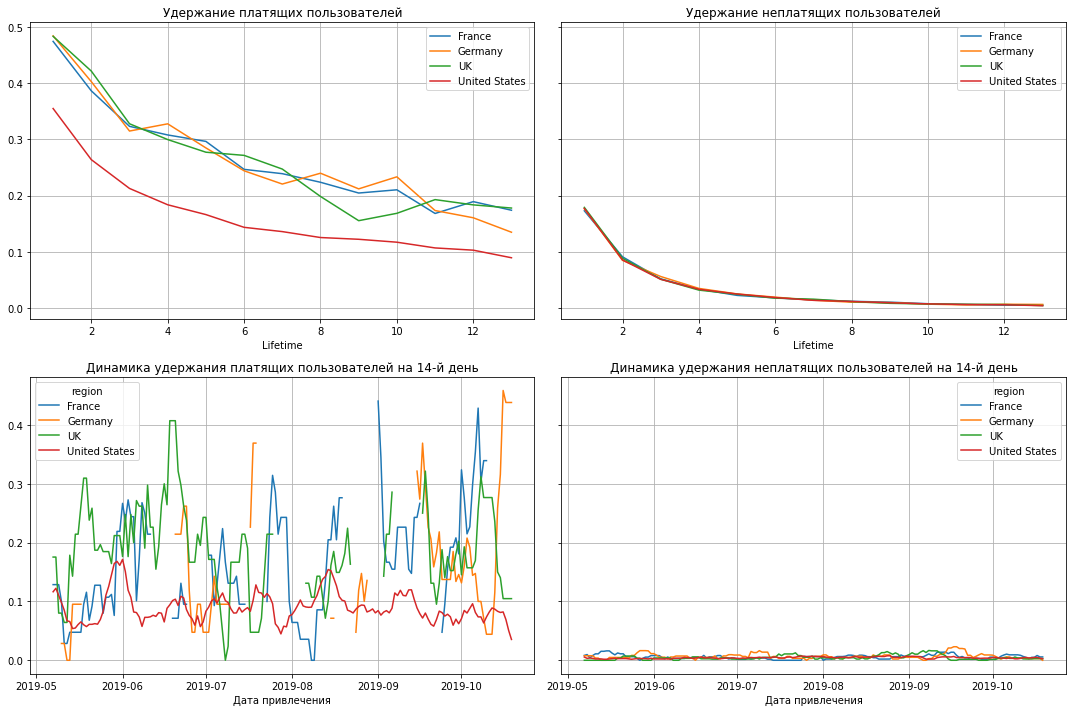

In [51]:
plot_retention(retention_country, 
               retention_country_history, 
               14, 
               7)

Графики показали - удержание платящих пользователей из США оказалось худшим среди регионов, а у остальных стран - примерно одинаковым. Удержание же неплатящих пользователей одинаково для всех регионов.

Динамика удержания платящих пользователей на 14 день также оказалась худшей для пользователей из США, притом она довольно равномерна для пользователей, привлечённых в разные даты - в среднем около 10%. А вот для пользователей из других стран наблюдается гораздо больший разброс значений удержания в зависимости от даты их привлечения: это, например, пик удержания платящих пользователей из Франции, привлечённых в конце августа/начале сентября - выше 40%, пик для платящих пользователей из Германии, привлечённых примерно в середине октября - также выше 40% и для пользователей из Великобритании, привлечённых в середине июня - около 40%.

Посмотрим также на конверсию в разрезе стран. В качестве момента анализа будем использовать последнюю дату привлечения пользователей, а в качестве горизонта анализа - 14 дней.

In [52]:
conversion_country_raw, conversion_country, conversion_country_history = get_conversion(profiles_ad,
                                                                                       orders,
                                                                                       observation_date,
                                                                                       horizon_days,
                                                                                       ['region'])

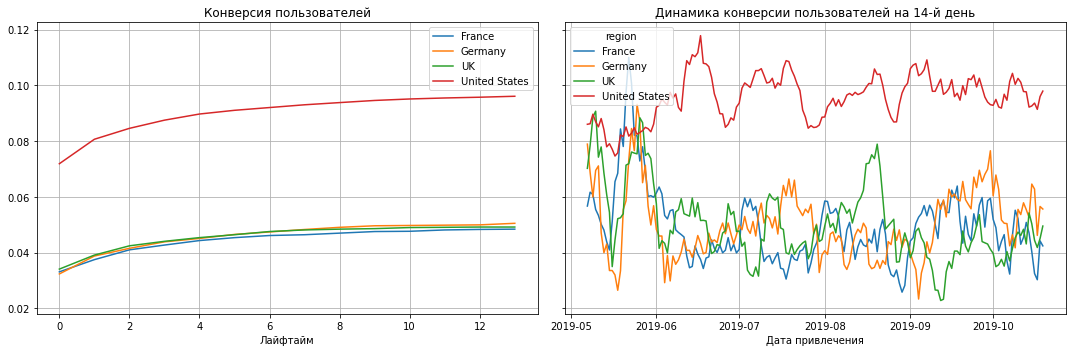

In [53]:
plot_conversion(conversion_country, 
                conversion_country_history, 
                14, 
                7)

На графиках конверсии в лидерах мы видим США - для этой страны конверсия составляет в среднем 9%, тогда как для остальных регионов этот показатель на уровне 4%. Динамика конверсии для США почти стабильна, за исключением пользователей, привлечённых в мае 2019г. Для остальных стран кривые динамики конверсии вторят друг другу, за исключением пика для пользователей из Великобритании, привлечённых в середине августа (почти 8%).

Судя по тому, что конверсия пользователей в платящих для США значительно выше, чем для других регионов, но при этом их удержание ниже, можно предположить, что пользователей из США заинтересовывают платные функции приложения, но они, очевидно, сталкиваются с какой-то проблемой при использовании этих функций, отсюда и более низкое удержание, или же совершают в приложении покупки на малую сумму (например, вместо периодических подписок приобретают какие-то единоразовые функции или только пробную подписку по сниженной цене). С учётом количества средств, вкладываемых в рекламные кампании на этом рынке, и получаемой выручки, стоит рассмотреть вопрос об уходе с рынка США.

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

Посмотрим на аналогичные графики, но уже в разрезе рекламных каналов:

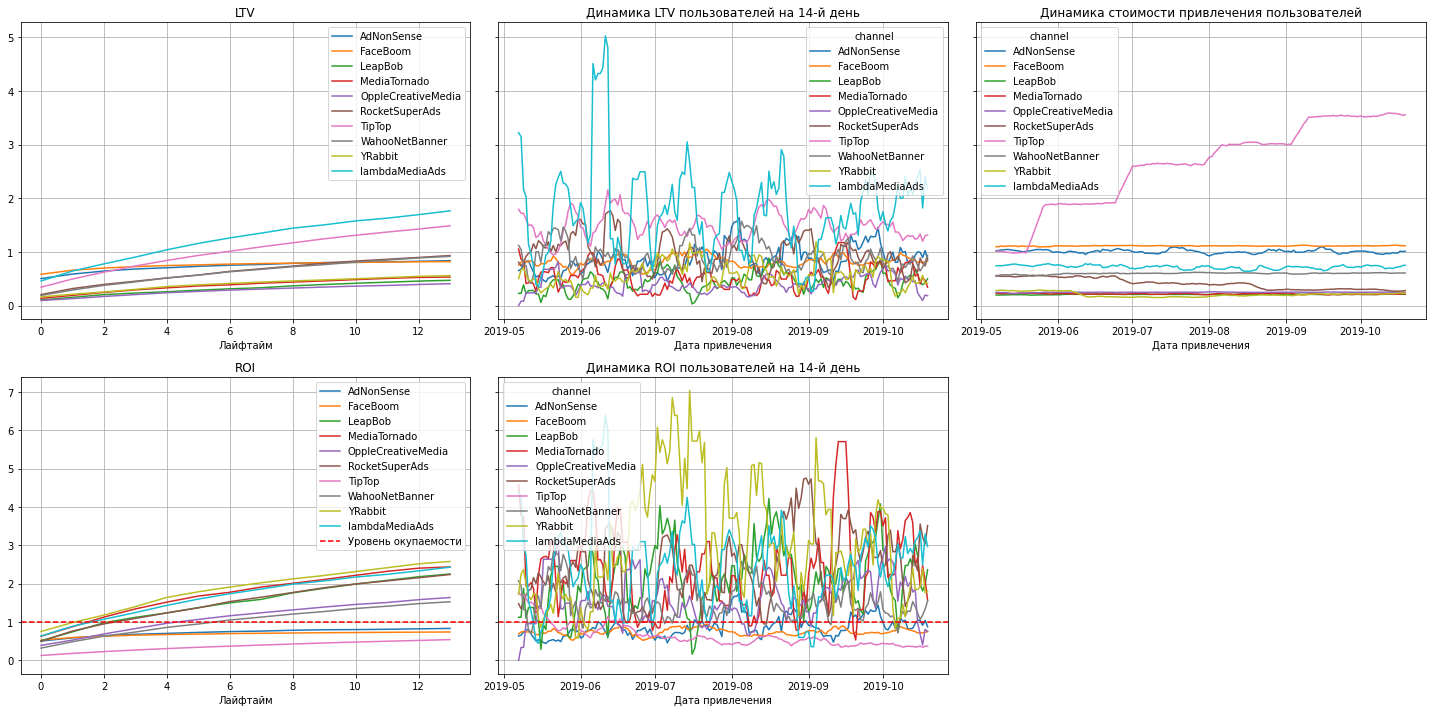

In [54]:
raw_channel_data, ltv_channel, ltv_channel_history, roi_channel, roi_channel_history = get_ltv(profiles_ad,
                                                                                               orders,
                                                                                               observation_date,
                                                                                               horizon_days,
                                                                                               dimensions = ['channel'])

plot_ltv_roi(ltv_channel, 
             ltv_channel_history, 
             roi_channel, 
             roi_channel_history, 
             horizon_days, 
             7)

На данных графиках видим ситуацию, схожую с анализом показателей по странам: затраты на привлечение пользователей из TipTop постоянно росли, но источник трафика так и не окупился. Интересно, что не окупились также источники AdNonSense и FaceBoom, хотя маркетинговые инвестиции в эти источники были примерно равномерны в течение периода анализа. Наиболее высокие показатели окупаемости на 14 день - у платформы YRabbit, она же - самый окупаемый источник трафика в целом. Также положительно себя показала платформа lambdaMediaAds - для неё мы видим наиболее высокий показатель пожизненной ценности клиентов.

Рассмотрим удержание пользователей в разрезе каналов привлечения.

In [55]:
retention_channel_raw, retention_channel, retention_channel_history = get_retention(profiles_ad,
                                                                                    visits,
                                                                                    observation_date,
                                                                                    horizon_days,
                                                                                    ['channel'])

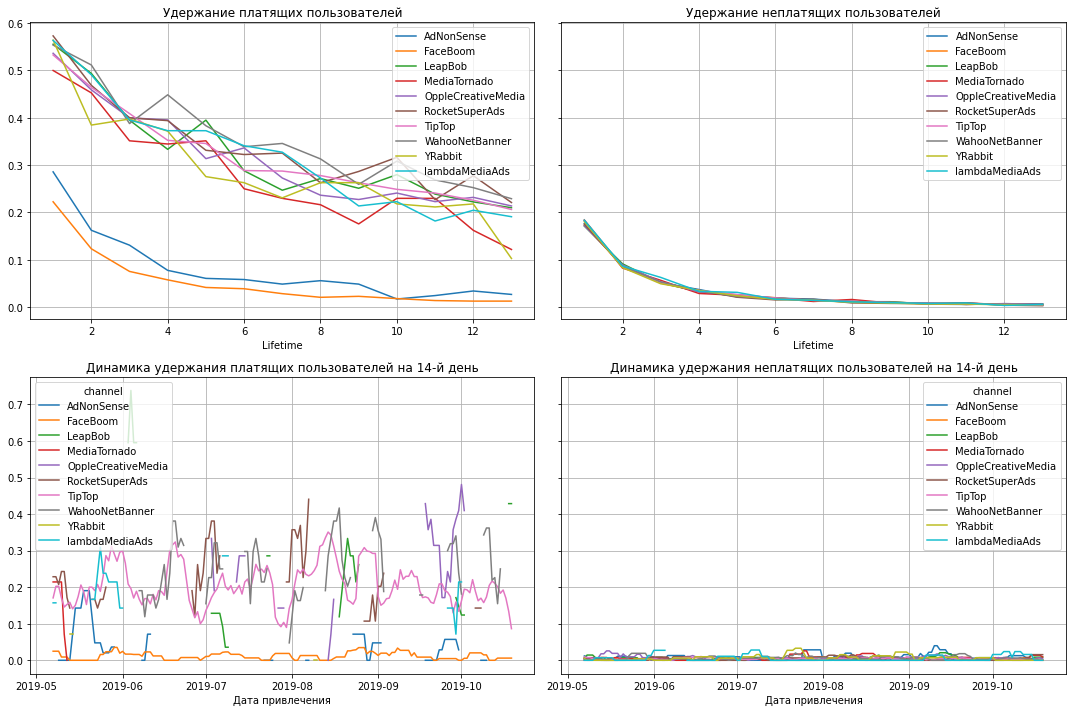

In [56]:
plot_retention(retention_channel, 
               retention_channel_history, 
               14, 
               7)

Наименьшее удержание пользователей - привлечённых из каналов AdNonSense и FaceBoom. Для пользователей, привлечённых из остальных каналов примерно одинаково - в среднем около 30-35%. Таким образом, вкладывать средства в рекламные кампании с размещением на AdNonSense и FaceBoom нерационально.

Аналогичную картину для данных двух источников мы видим и по графику удержания платящих пользователей на 14 день - для них кривые динамики также самые низкие. 

Проверим конверсию с разбивкой по источникам трафика:

In [57]:
conversion_channel_raw, conversion_channel, conversion_channel_history = get_conversion(profiles_ad,
                                                                                        orders,
                                                                                        observation_date,
                                                                                        horizon_days,
                                                                                        ['channel'])

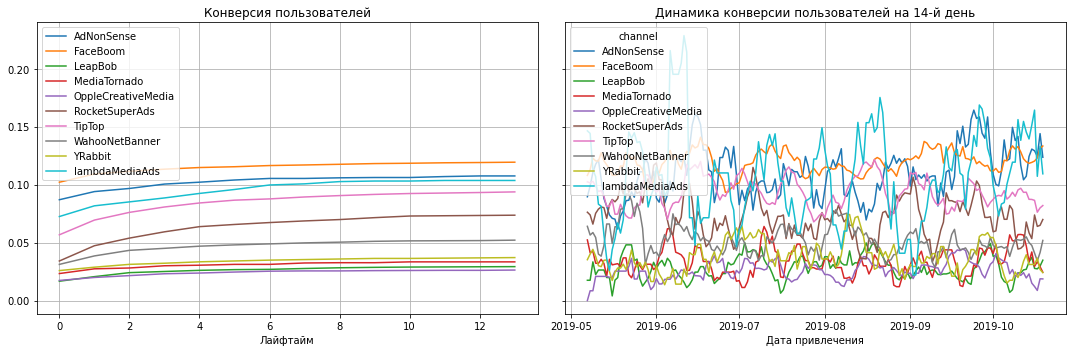

In [58]:
plot_conversion(conversion_channel, 
                conversion_channel_history, 
                14, 
                7)

Наиболее высокая конверсия - для пользователей, привлечённых с FaceBoom (около 11% в среднем), а наименее высокую конверсию выделить сложно - для нескольких источников она почти одинакова.

Учитывая все проанализированные показатели, необходимо рассмотреть вопрос отказа от размещения рекламы в таких источниках, как TipTop, FaceBoom и AdNonSense - стоимость привлечения пользователей с этих платформ высока, а для TipTop ещё и росла на протяжении рассматриваемого периода, однако кампании не окупились и, к тому же, показали низкое удержание пользователей. Расходовать такую долю бюджета на эти источники - нерационально.

## Выводы

**Анализ расходов на маркетинг и эффективности рекламных кампаний показал следующее:**
1. На этапе предобработки данных не было выявлено ни пропусков, ни дубликатов в таблице. Для целей проведения анализа были только преобразованы типы данных, в остальном данные были пригодны для анализа;


2. В ходе анализа привлечённых пользователей в разрезе стран, устройств и каналов привлечения выяснено, что:
    - бóльшая часть пользователей - из США (более 100 000 человек), наибольшая доля платящих пользователей - также из США (около 7%). Доли платящих пользователей из остальных регионов почти одинаковы - около 4%;
    - доли платящих пользователей Mac, iPhone и Android примерно одинаковы - около 6%, а вот пользователей ПК среди платящих несколько меньше - 5%;
    - наиболее высокий процент платящих пользователей был привлечён из FaceBoom (12%), а наименьший процент, ожидаемо, принадлежит "орагническим" пользователям (2%). При этом шаг между долями разных источников трафика небольшой - 1-2%;


3. За исследуемый период в целом в рекламу было вложено 105497.3$. Большая часть этих средств была вложена в привлечение трафика из источников TipTop (52% затрат) и FaceBoom (почти 31% затрат). При этом на протяжении рассматриваемого периода рекламные вложения в трафик из этих источников постоянно росли. 


4. При расчёте стоимости привлечения пользователей из разных каналов обнаружено, что самым дорогим источником трафика является TipTop. Стоимость одного пользователя для этого источника - свыше 2,5 долл., тогда как пользователи из следующего по дороговизне источника (FaceBoom) обходятся почти в 2,5 раза дешевле - чуть выше 1 долл. Стоит отметить, что в среднем привлечение одного пользователя стоит 1,11 долл. - стоимость пользователей из TipTop выше в 2,5 раза;


5. За весь рассматриваемый период маркетинговые расходы не окупились. Этому способствовали, в том числе, постоянный рост стоимости привлечения пользователей и увеличение расходов на проведение кампаний;


6. Рекламные кампании, нацеленные на пользователей устройств Apple, не окупаются. При этом они составляют большую долю пользователей приложения в общем. *Стоит выяснить, в чём отличие поведения пользователей-владельцев устройств Apple* - возможно, функционал приложения на этих устройствах работает неожиданным образом или пользователи сталкиваются с какими-либо ошибками при использовании приложения или при попытке оплаты. Пользователи ПК показывают наивысший показатель удержания и наиболее высокую окупаемость, но конверсия их ниже, чем для других устройств. *Возможно, стоит поработать над содержанием рекламных кампаний для пользователей ПК для увеличения конверсии*;


7. США - единственная страна, для которой стоимость пользователя росла на протяжении всего периода, и единственная страна, рекламные кампании в которой не окупились. С учётом количества средств, вкладываемых в рекламные кампании на этом рынке, и получаемой выручки, *стоит рассмотреть вопрос об уходе с рынка США*. В то же время пользователи всех остальных регионов окупились примерно в 1,5 раза при снижении маркетинговых затрат относительно первого месяца;


8. Необходимо *рассмотреть вопрос отказа от размещения рекламы в таких источниках, как TipTop, FaceBoom и AdNonSense* - стоимость привлечения пользователей с этих платформ высока, а для TipTop ещё и росла на протяжении рассматриваемого периода, однако кампании не окупились и, к тому же, показали низкое удержание пользователей. Расходовать такую долю бюджета на эти источники - нерационально. Более пристальное внимание следует уделить платформам:
    - YRabbit, как самому окупаемому источнику трафика в целом;    
    - lambdaMediaAds - для неё мы видим наиболее высокий показатель пожизненной ценности клиентов.